In [ ]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import glob
import os
import zarr
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
import h5py

from colormap import *

from unet import *

tf.executing_eagerly()


Training an Instance Segmentation model
==================================

So far we were only interested in classes, what is background and foreground, 
where are cells or person vs car. But in many cases we not only want to know
if a certain pixel belongs to a cell, but also to which cell.

For isololated objects, this is trivial, all connected foreground pixels form
one instance, yet often instances are very close together or even overlapping.
Then we need to think a bit more how to formulate the loss for our network
and how to extract the instances from the predictions.

Data
-------
For this task we are using a subset of the data used in a kaggle challenge
(https://www.kaggle.com/c/data-science-bowl-2018/)

Two example images:
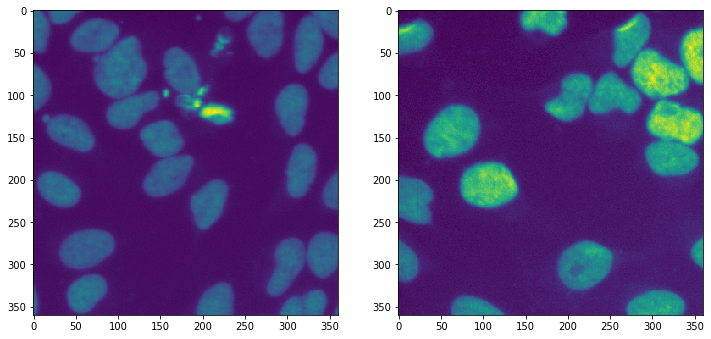

All images show nuclei recorded using different microscopes and lightning conditions.
There are 30 images in the training set, 8 in the validation set and 16 in the test set.

In [ ]:
class KaggleDSB_dataset(tf.keras.utils.Sequence):
    """(subset of the) kaggle data science bowl 2018 dataset.
    The data is loaded from disk on the fly and in parallel using the keras Sequence class.
    This enables the use of datasets that would not fit into main memory and dynamic augmentation.
    Args:
        root_dir (string): Directory with all the images.
        kind (string): train/val/test, select subset of images
        transform (callable, optional): Optional transform to be applied
        on a sample.
    """
    def __init__(self, root_dir, data_type, batch_size, shuffle, prediction_type="two_class"):
        self.data_type = data_type
        self.files = glob.glob(os.path.join(root_dir, data_type, "*.zarr"))[:8]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.prediction_type = prediction_type

    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.files)
    
    def get_filename(self, idx):
        start_idx = min(idx * self.batch_size, len(self.files) - 1)
        end_idx = min(idx * self.batch_size + self.batch_size, len(self.files))
        return self.files[start_idx:end_idx]

    def __getitem__(self, idx):
        images = []
        labels = []
        for i in range(self.batch_size):
            fn = self.files[min(idx * self.batch_size + i, len(self.files) - 1)]
            #print(fn)
            data = zarr.open(fn)
            image = np.array(data['volumes/raw'])
            if self.prediction_type == "two_class":
                label = np.array(data['volumes/gt_fgbg'])
            elif self.prediction_type == "affinities":
                label = np.array(data['volumes/gt_affs'])
            elif self.prediction_type == "sdt":
                label = np.array(data['volumes/gt_tanh'])
            elif self.prediction_type == "three_class":
                label = np.array(data['volumes/gt_threeclass'])
            label = label.astype(np.float32)

            if self.data_type == "train":
                # add augmentation here, e.g.:
                # image = tf.image.random_brightness(image, 0.1)
                # be aware that some augmentations only apply to the raw data while others to both raw data and labels
                # image, label = tf.split(tf.keras.preprocessing.image.random_rotation(
                #    tf.concat([image, label], axis=0), 10, fill_mode='constant'), 2)
                # for more information see: (functions: ...random_...)
                # https://www.tensorflow.org/api_docs/python/tf/image
                # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image?version=stable
                pass
            
                image = tf.transpose(image, [1, 2, 0])
                label = tf.transpose(label, [1, 2, 0])

                # image = tf.image.random_brightness(image, 0.1)
                # image = tf.image.random_contrast(image, 0.9, 1.1)
                tmp = tf.image.random_flip_left_right(tf.concat([image, label], axis=2))
                if self.prediction_type == "affinities":
                    image, label = tf.split(tmp, [1, 2], axis=2)
                else:
                    image, label = tf.split(tmp, 2, axis=2)
                tmp = tf.image.random_flip_up_down(tf.concat([image, label], axis=2))
                if self.prediction_type == "affinities":
                    image, label = tf.split(tmp, [1, 2], axis=2)
                else:
                    image, label = tf.split(tmp, 2, axis=2)
                # image, label = tf.split(tf.keras.preprocessing.image.random_shift(
                #     tf.concat([image, label], axis=0), 0.1, 0.1, fill_mode='constant'), 2)
                # image, label = tf.split(tf.keras.preprocessing.image.random_shear(
                #     tf.concat([image, label], axis=0), 10, fill_mode='constant'), 2)
                # image, label = tf.split(tf.keras.preprocessing.image.random_zoom(
                #     tf.concat([image, label], axis=0), (1.1, 1.2), fill_mode='constant'), 2)
                # image, label = tf.split(tf.keras.preprocessing.image.random_rotation(
                #     tf.concat([image, label], axis=0), 10, fill_mode='constant'), 2)
                
                image = tf.transpose(image, [2, 0, 1])
                label = tf.transpose(label, [2, 0, 1])

            images.append(image)
            labels.append(label)
        return tf.stack(images, axis=0), tf.stack(labels, axis=0)

Loss
-------
There are many different approaches to instance segmentation.
We will introduce three basic methods:

### Three-class model ###
This is an extension of the basic foreground/background (or two-class) model.
In addition a third class is introduced: the boundary.
Even if two instances are touching, there is a boundary between them. This way they can be separated. 
Instead of a single output (where an output of zero is one class and of one is the other class), the network outputs three values, one per class. And the loss function changes from binary to (sparse) categorical cross entropy.

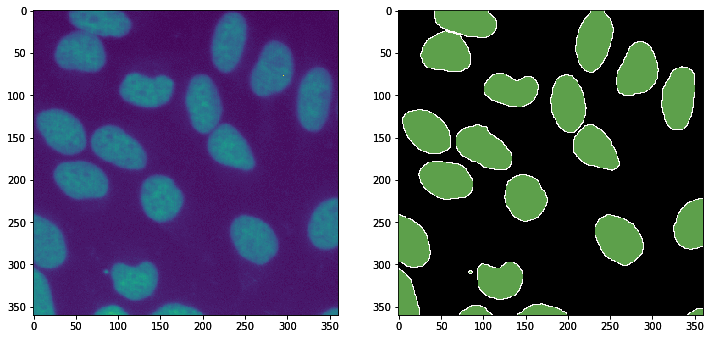

### Distance Transform ###
The label for each pixel is the distance to the closest boundary. 
The value within instances is negative and outside of instances is positive.
As the output is not a probability but an (in principle) unbounded scalar, the mean squared error loss function is used.

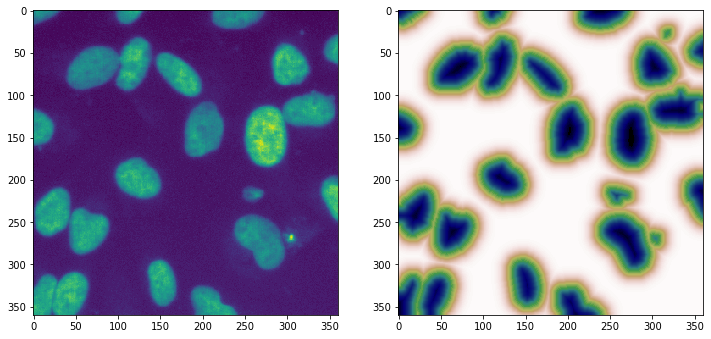


### Edge Affinities ###
Here we consider not just the pixel but also its direct neighbors (in 2D the left neighbor and the upper neighbor are sufficient, right and down are redundant with the next pixel's left and upper neighbor).
Imagine there is an edge between two pixels if they are in the same class and no edge if not. If we then take all pixels that are directly and indirectly connected by edges, we get an instance. The network predicts the probability that there is an edge, this is call affinity.
As we are considering two neighbors per pixel, our network needs two outputs and as the output is a probability, we are using binary cross entropy

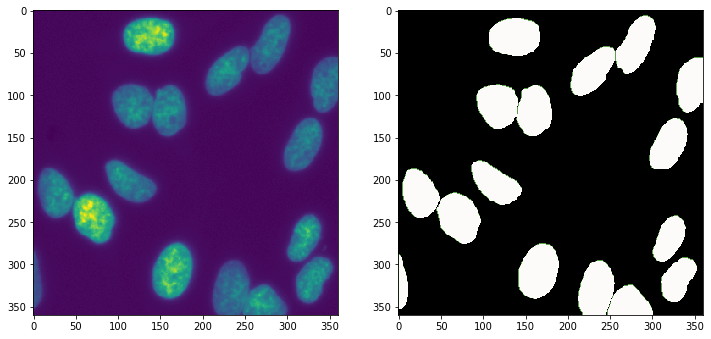



In [ ]:
#prediction_type = "two_class" # same as fg/bg
#prediction_type = "affinities"
prediction_type = "sdt"
#prediction_type = "three_class"

if prediction_type == "two_class":
    out_channels = 1
    activation = tf.keras.layers.Activation("sigmoid")
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
elif prediction_type == "affinities":
    out_channels = 2
    activation = tf.keras.layers.Activation("sigmoid")
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
elif prediction_type == "sdt":
    out_channels = 1
    activation = None
    loss = tf.keras.losses.MeanSquaredError()
elif prediction_type == "three_class":
    out_channels = 3
    activation = tf.keras.layers.Activation("softmax")
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
else:
    raise RuntimeError("invalid prediction type")

Create our input datasets, ground truth labels are chosen depending on the type:

In [ ]:
data_train = KaggleDSB_dataset("data_kaggle_test", "train", 8, prediction_type=prediction_type, 
                               shuffle=True)
data_val = KaggleDSB_dataset("data_kaggle_test", "val", 8, prediction_type=prediction_type, 
                             shuffle=False)
data_test = KaggleDSB_dataset("data_kaggle_test", "test", 1, prediction_type=prediction_type, 
                              shuffle=False)

Let's have a look at some of the raw data and labels:


In [ ]:
# repeatedly execute this cell to get different images
images, labels = data_train[random.randrange(len(data_train))]
rnd = random.randrange(len(images))
image = images[rnd]
label = labels[rnd]

if prediction_type == "affinities":
    label = label[0] + label[1]

fig=plt.figure(figsize=(12, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(label), cmap='gist_earth')

### Receptive Field of View

In [ ]:
images, labels = data_train[random.randrange(len(data_train))]
rnd = random.randrange(len(images))
image = images[rnd]
label = labels[rnd]

net_input_t = tf.keras.Input(shape=(1, 360, 360), name='img')
net_t = net_input_t
net_t = tf.keras.layers.ZeroPadding2D(12, data_format='channels_first')(net_input_t)
fovs = []
_, fov_tmp = unet(net_t, out_channels, depth=1, num_fmaps=32)
fovs.append(fov_tmp)
_, fov_tmp = unet(net_t, out_channels, depth=2, num_fmaps=32)
fovs.append(fov_tmp)
_, fov_tmp = unet(net_t, out_channels, depth=3, num_fmaps=32)
fovs.append(fov_tmp)
_, fov_tmp = unet(net_t, out_channels, depth=4, num_fmaps=32)
fovs.append(fov_tmp)
_, fov_tmp = unet(net_t, out_channels, depth=5, num_fmaps=32)
fovs.append(fov_tmp)

fig=plt.figure(figsize=(8, 8))
colors = ["yellow", "red", "green", "blue", "magenta"]
plt.imshow(np.squeeze(image, axis=0), cmap='gray')
for idx, fov_t in enumerate(fovs):
    print("Field of view at depth {}: {:3d} (color: {})".format(idx+1, fov_t, colors[idx]))
    xmin = image.shape[1]/2 - fov_t/2
    xmax = image.shape[1]/2 + fov_t/2
    ymin = image.shape[1]/2 - fov_t/2
    ymax = image.shape[1]/2 + fov_t/2
    plt.hlines(ymin, xmin, xmax, color=colors[idx], lw=3)
    plt.hlines(ymax, xmin, xmax, color=colors[idx], lw=3)
    plt.vlines(xmin, ymin, ymax, color=colors[idx], lw=3)
    plt.vlines(xmax, ymin, ymax, color=colors[idx], lw=3)
plt.show()

Define our U-Net
==============
As before, we define our neural network architecture and can choose the depth and number of feature maps at the first convolution.



In [ ]:
tf.keras.backend.clear_session()

net_input = tf.keras.Input(shape=(1, 360, 360), name='img')
net = net_input

# add some zero padding, makes the 2x2 pooling more straight forward
net = tf.keras.layers.ZeroPadding2D(12, data_format='channels_first')(net_input)

# heads up: no activation as loss uses logits
net_output, fov = unet(net, out_channels, depth=3, num_fmaps=32)

# remove zero padding
net_output = tf.keras.layers.Cropping2D(12, data_format='channels_first')(net_output)

# for the three class loss, tensorflow expects the channels dimension as the last dimension
if prediction_type == "three_class":
    net_output = tf.transpose(net_output, [0, 2, 3, 1])

net = tf.keras.Model(net_input, net_output, name='unet')

print("Receptive field of view: {}".format(fov))
net.summary()

Training
=======

Before we start training, we have to compile the network and set the optimizer (try playing with the learning rate, a higher learning rate can lead to faster training, but also to divergence or lower performance).

To visualize our results we now use Tensorboard. This is a very useful extension for your browser that let's you look network graph and the weights and metrics over time.

In [ ]:
net.compile(# Optimizer
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss=loss)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%reload_ext tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=10)

In [ ]:
# takes ~3:20min
history = net.fit_generator(data_train,
                  epochs=100,
                  # We pass some validation for
                  # monitoring validation loss and metrics
                  # at the end of each epoch
                  validation_data=data_val,
                  initial_epoch=0,
                  callbacks=[tensorboard_callback])

print('Finished Training')
!ps aux | grep --color=auto tensorboard | grep --color=auto 6014 | awk '{print $2}' | xargs kill
%tensorboard --logdir $logdir --port 6014

Postprocessing
=============

In contrast to the semantic segmentation we postprocessing to extract the final segmentation is a bit more involved and consists of x steps:
- based on the prediction we define a surface
- we extract the maxima from this surface
- we use the maxima as seeds in an off-the-shelf watershed algorithm
- and mask the result with the foreground
The foreground areas covered by the watershed from each seed point correspond to the instances.
The resulting instances are then matched to the ground truth instances (at least 50% overlap) to get our final score (averaged over all instances and all test images)

In [ ]:
%reload_ext autoreload
%autoreload 2
from label import *
from evaluate import *

avg = 0.0
for idx, pred in enumerate(net.predict_generator(data_test)):
    # thresholds are hyperparameter of the model and have to be tuned after training on the validation set
    if prediction_type == "two_class":
        fg_thresh = 0.7
        seed_thresh = 0.8
    elif prediction_type == "three_class":
        pred = np.transpose(pred, [2, 0, 1])
        fg_thresh = 0.5
        seed_thresh = 0.6
    elif prediction_type == "sdt":
        fg_thresh = 0.0
        seed_thresh = -0.12
    elif prediction_type == "affinities":
        fg_thresh = 0.9
        seed_thresh = 0.99

    image = np.squeeze(data_test[idx][0])
    gt_labels = np.squeeze(data_test[idx][1])
    if prediction_type == "affinities":
        gt_labels = gt_labels[0] + gt_labels[1]

    labelling, surface = label(pred, prediction_type, fg_thresh=fg_thresh, seed_thresh=seed_thresh)
    ap, precision, recall, tp, fp, fn = evaluate(labelling, data_test.get_filename(idx)[0])
    avg += ap
    print(np.min(surface), np.max(surface))
    labelling = labelling.astype(np.uint8)
    print("average precision: {}, precision: {}, recall: {}".format(ap, precision, recall))
    print("true positives: {}, false positives: {}, false negatives: {}".format(tp, fp, fn))
    
    fig=plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 4, 1)
    ax.set_title("raw")
    plt.imshow(np.squeeze(image))
    ax = fig.add_subplot(1, 4, 2)
    ax.set_title("gt labels")
    plt.imshow(np.squeeze(1.0-gt_labels))
    
    ax = fig.add_subplot(1, 4, 3)
    ax.set_title("prediction")
    plt.imshow(np.squeeze(1.0-surface))
    ax = fig.add_subplot(1, 4, 4)
    ax.set_title("pred segmentation")
    plt.imshow(np.squeeze(labelling), cmap=rand_cmap)

    plt.show()
avg /= (idx+1)
print("average precision on test set: {}".format(avg))